<h1 style="text-align: center;">Breaking RSA: An Implementation of Shor's Algorithm in Quantum Cryptography</h1>
<br>
<p style="text-align: center;"><strong>Prepared for:</strong> Dr. Sultan Almuhammadi</p>
<p style="text-align: center;"><strong>Prepared by:</strong> Ahmed Almalki</p>
<hr>

## Abstract:
This project explores the practical application of Shor's algorithm in breaking RSA encryption through quantum computing. My objective is to implement Shor's algorithm using Qiskit, an open-source quantum computing software development framework, to demonstrate the vulnerability of public-key cryptographic systems to quantum attacks. To date, I have developed a quantum circuit that successfully factors integers using simulated quantum processors. The implementation has been tested on small integers to validate the algorithm's functionality. Preliminary time complexity analysis suggests scalability to more significant integers with an increase in qubit resources. My ongoing work aims to refine the algorithm's efficiency and prepare for a demonstration on an actual quantum processor.

In [22]:
from qiskit import QuantumCircuit, QuantumRegister, ClassicalRegister, execute, Aer, IBMQ
from qiskit.visualization import plot_histogram, circuit_drawer, plot_state_city, plot_state_hinton

from qiskit.providers.ibmq import least_busy
from qiskit.compiler import transpile, assemble
from qiskit.tools.monitor import job_monitor

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

import math
from fractions import Fraction


In [23]:
def run_on_simulation(qc, shots=100):
#     simulator = Aer.get_backend('qasm_simulator')
    simulator = Aer.get_backend('statevector_simulator')
    job = execute(qc, simulator, shots=shots)

    return job.result()

def least_busy_backend(n_qubits):
    IBMQ.load_account()
    provider = IBMQ.get_provider(hub='ibm-q')
    backend = least_busy(provider.backends(filters=lambda x: x.configuration().n_qubits >= (n_qubits+1) and
                                       not x.configuration().simulator and x.status().operational==True))
    print("least busy backend: ", backend)
    
    return backend


def run_on_IBMQ(qc, backend, shots=100):
    transpiled_qc = transpile(qc, backend, optimization_level=3)
    job = backend.run(transpiled_qc, shots=shots)
    job_monitor(job, interval=2)
    
    return job.result()


In [73]:
def c_amodN(a, N, power):
    as_xs={}
    n_len = math.ceil(math.log2(N))
    m_len = 2*n_len
    
    for n in range(2,N):
        if math.gcd(n,N)==1:
            as_xs[n]=format(n^1, f'0{n_len}b')
    
    if a not in list(as_xs.keys()):
        raise ValueError(f"'a' must be {list(as_xs.keys())}")
    U = QuantumCircuit(n_len)
    
#     for i, bit in enumerate(as_xs[a][::-1]):
    for i, bit in enumerate(as_xs[a]):
        if bit == '1':
            U.x(i)

    U = U.to_gate()
    U.name = f"{a}^{power} mod {N}"
    c_U = U.control()
    return c_U


def c_amodN_print(N):
    as_xs={}
    n_len = math.ceil(math.log2(N))
    m_len = 2*n_len
    
    for n in range(2,N):
        if math.gcd(n,N)==1:
            as_xs[n]=format(n^1, f'0{n_len}b')
    
    if a not in list(as_xs.keys()):
        raise ValueError(f"'a' must be {list(as_xs.keys())}")
    
    for a_int, a_bin in as_xs.items():
        U = QuantumCircuit(n_len)
        print(f"a(int)=\t {a_int}", f"\na(bin)=\t {format(a_int, f'0{n_len}b')}", f"\nx_gates= {a_bin}")
        for i, bit in enumerate(format(a_int, f'0{n_len}b')):
            if bit == '1':
                U.x(i)
        U.barrier()
        for i, bit in enumerate(as_xs[a_int]):
            if bit == '1':
                U.x(i)
        display(U.draw('mpl'))

    return U

a(int)=	 2 
a(bin)=	 0010 
x_gates= 0011


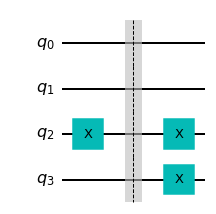

a(int)=	 4 
a(bin)=	 0100 
x_gates= 0101


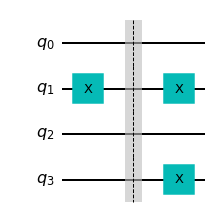

a(int)=	 7 
a(bin)=	 0111 
x_gates= 0110


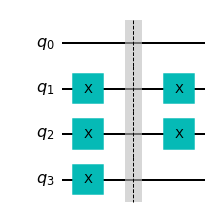

a(int)=	 8 
a(bin)=	 1000 
x_gates= 1001


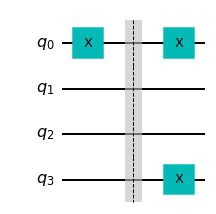

a(int)=	 11 
a(bin)=	 1011 
x_gates= 1010


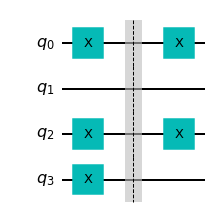

a(int)=	 13 
a(bin)=	 1101 
x_gates= 1100


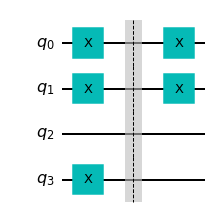

a(int)=	 14 
a(bin)=	 1110 
x_gates= 1111


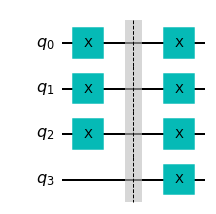

In [149]:
c_amodN_print(15)

In [150]:
def qft_dagger(n):
    """n-qubit QFTdagger the first n qubits in circ"""
    qc = QuantumCircuit(n)
    # Don't forget the Swaps!
    for qubit in range(n//2):
        qc.swap(qubit, n-qubit-1)
    for j in range(n):
        for m in range(j):
            qc.cp(-np.pi/float(2**(j-m)), m, j)
        qc.h(j)
    qc.name = "QFT†"
    return qc

In [232]:
N=21
a=8
n_len = math.ceil(math.log2(N))
m_len = 2*n_len

In [270]:
from qiskit.circuit.library import QFT

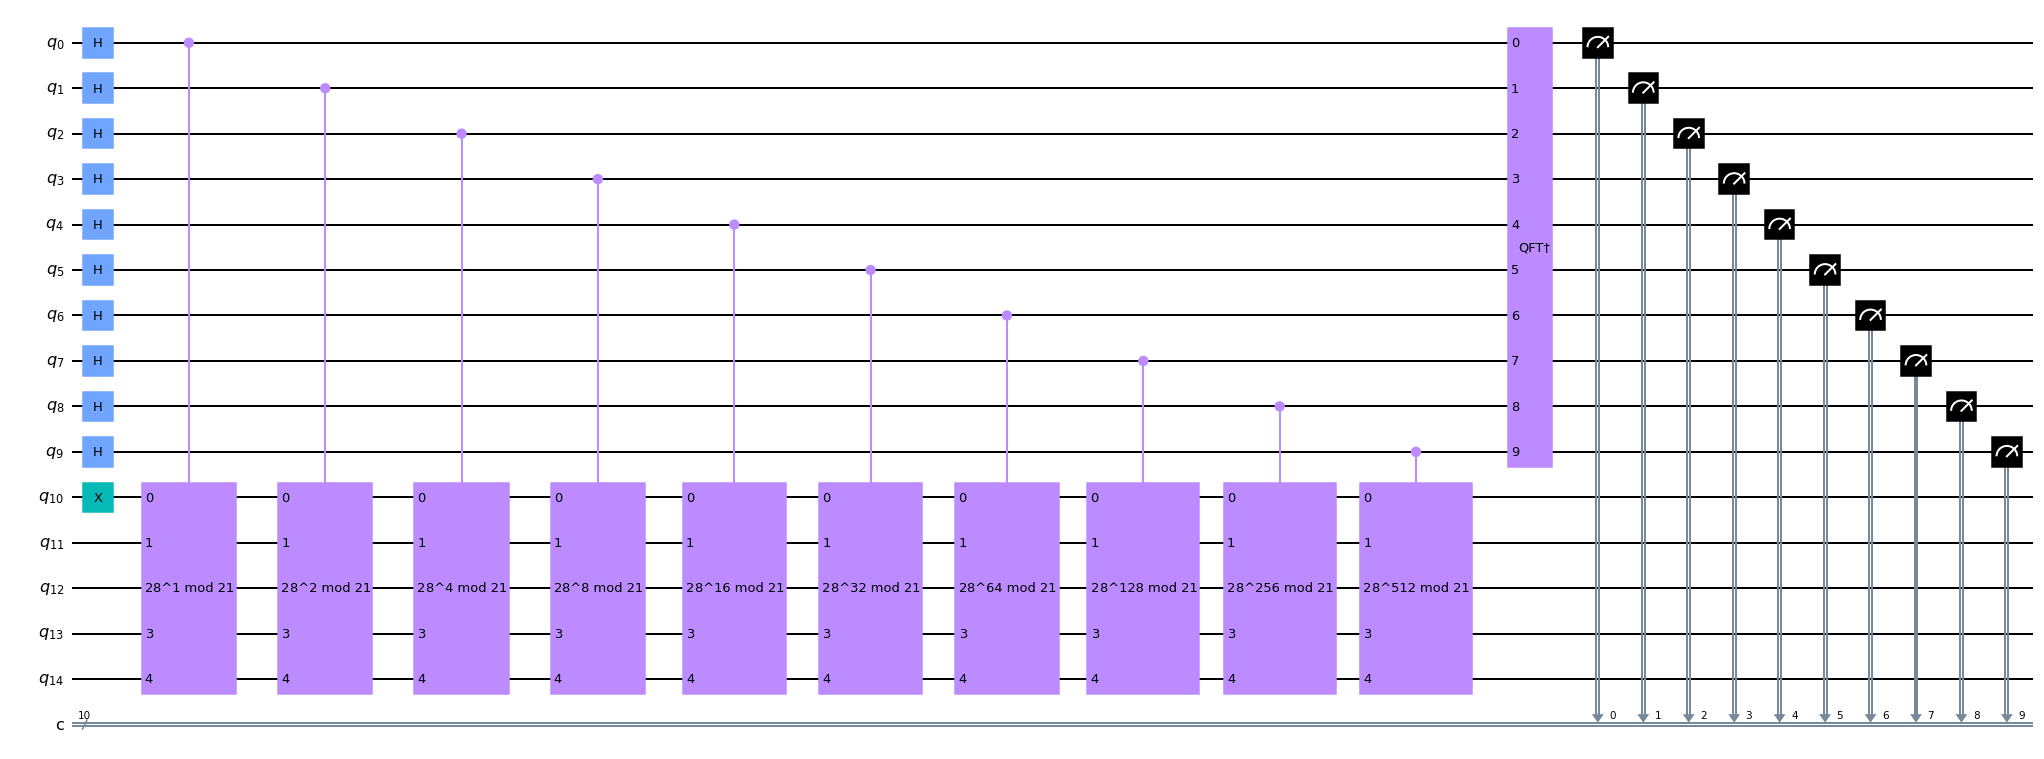

In [277]:
qc = QuantumCircuit(m_len + n_len, m_len)

# Initialize counting qubits
# in state |+>
for q in range(m_len):
    qc.h(q)

# And auxiliary register in state |1>
qc.x(m_len)

# Do controlled-U operations
for q in range(m_len):
    qc.append(c_amodN(a, N, 2**q),
             [q] + [i+m_len for i in range(n_len)])

# Do inverse-QFT
qc.append(qft_dagger(m_len), range(m_len))
# qc.append(QFT(m_len, inverse=True), range(m_len))
# qc.append(QFT(m_len).inverse(), range(m_len))


# Measure circuit
qc.measure(range(m_len), range(m_len))
qc.draw(fold=-1, output='mpl', style='clifford')  # -1 means 'do not fold'

In [278]:
# counts = run_on_simulation(qc).get_counts()
# plot_histogram(counts, figsize=(17, 5))

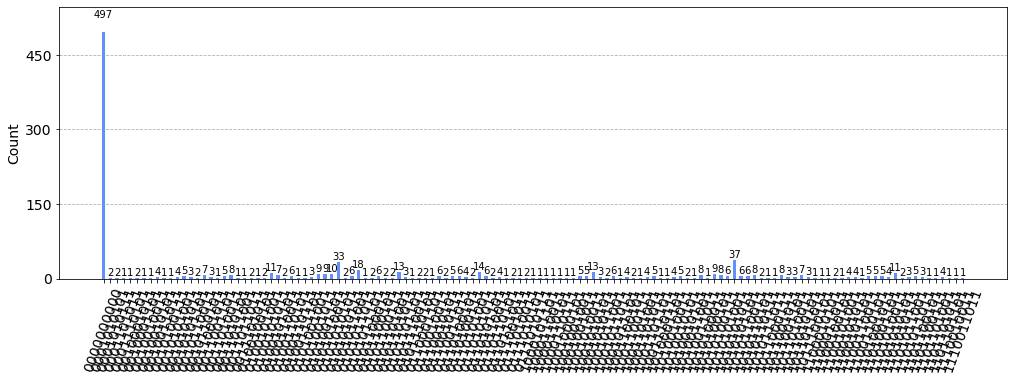

In [279]:
aer_sim = Aer.get_backend('aer_simulator')
t_qc = transpile(qc, aer_sim)
counts = aer_sim.run(t_qc).result().get_counts()
plot_histogram(counts, figsize=(17, 5))

# _counts = counts.copy()
# del _counts['0'*m_len]
# plot_histogram(_counts, figsize=(17, 5))

In [280]:
rows, measured_phases = [], []
for output in _counts:
    decimal = int(output, 2)  # Convert (base 2) string to decimal
    phase = decimal/(2**m_len)  # Find corresponding eigenvalue
    measured_phases.append(phase)
    # Add these values to the rows in our table:
    rows.append([f"{output}(bin) = {decimal:>3}(dec)",
                 f"{decimal}/{2**m_len} = {phase:.2f}"])
# Print the rows in a table
headers=["Register Output", "Phase"]
df = pd.DataFrame(rows, columns=headers)
print(df)

                Register Output            Phase
0    0010011011(bin) = 155(dec)  155/1024 = 0.15
1    1011010101(bin) = 725(dec)  725/1024 = 0.71
2    1100110101(bin) = 821(dec)  821/1024 = 0.80
3    0010110011(bin) = 179(dec)  179/1024 = 0.17
4    0011010101(bin) = 213(dec)  213/1024 = 0.21
..                          ...              ...
126  0001010101(bin) =  85(dec)   85/1024 = 0.08
127  0100100101(bin) = 293(dec)  293/1024 = 0.29
128  0001100111(bin) = 103(dec)  103/1024 = 0.10
129  1001011001(bin) = 601(dec)  601/1024 = 0.59
130  1011010001(bin) = 721(dec)  721/1024 = 0.70

[131 rows x 2 columns]


In [237]:
rows = []
for phase in measured_phases:
    frac = Fraction(phase).limit_denominator(N)
    rows.append([phase,
                 f"{frac.numerator}/{frac.denominator}",
                 frac.denominator])
# Print as a table
headers=["Phase", "Fraction", "Guess for r"]
df = pd.DataFrame(rows, columns=headers)
print(df)

        Phase Fraction  Guess for r
0    0.151367     3/20           20
1    0.708008    12/17           17
2    0.801758      4/5            5
3    0.174805     3/17           17
4    0.208008     4/19           19
..        ...      ...          ...
126  0.083008     1/12           12
127  0.286133      2/7            7
128  0.100586     1/10           10
129  0.586914    10/17           17
130  0.704102    12/17           17

[131 rows x 3 columns]


In [238]:
# df['Guess for r'].value_counts()

In [239]:
# df.groupby('Guess for r').sum('Phase').sort_values('Phase')

In [240]:
# df.groupby('Guess for r').max('Phase').sort_values('Phase')

In [241]:
math.gcd(a, N)

1

In [242]:
def qpe_amodN(a, N):
    """Performs quantum phase estimation on the operation a*r mod 15.
    Args:
        a (int): This is 'a' in a*r mod 15
    Returns:
        float: Estimate of the phase
    """
    qc = QuantumCircuit(n_len+m_len, m_len)
    for q in range(m_len):
        qc.h(q)     # Initialize counting qubits in state |+>
    qc.x(m_len) # And auxiliary register in state |1>
    for q in range(m_len): # Do controlled-U operations
        qc.append(c_amodN(a, N, 2**q),
                 [q] + [i+m_len for i in range(n_len)])
    qc.append(qft_dagger(m_len), range(m_len)) # Do inverse-QFT
    qc.measure(range(m_len), range(m_len))
    # Simulate Results
    aer_sim = Aer.get_backend('aer_simulator')
    # `memory=True` tells the backend to save each measurement in a list
    job = aer_sim.run(transpile(qc, aer_sim), shots=1, memory=True)
    readings = job.result().get_memory()
    print("Register Reading: " + readings[0])
    phase = int(readings[0],2)/(2**m_len)
    print(f"Corresponding Phase: {phase}")
    return phase

In [266]:
phase = qpe_amodN(a, N) # Phase = s/r
Fraction(phase).limit_denominator(N)

Register Reading: 0110101101
Corresponding Phase: 0.4189453125


Fraction(8, 19)

In [267]:
frac = Fraction(phase).limit_denominator(N)
s, r = frac.numerator, frac.denominator
print(r)

19


In [268]:
guesses = [math.gcd(a**(r//2)-1, N), math.gcd(a**(r//2)+1, N)]
print(guesses)

[7, 3]


In [269]:
FACTOR_FOUND = False
ATTEMPT = 0
while not FACTOR_FOUND:
    ATTEMPT += 1
    print(f"\nATTEMPT {ATTEMPT}:")
    phase = qpe_amodN(a, N) # Phase = s/r
    frac = Fraction(phase).limit_denominator(N)
    r = frac.denominator
    print(f"Result: r = {r}")
    if phase != 0:
        # Guesses for factors are gcd(x^{r/2} ±1 , 15)
        guesses = [math.gcd(a**(r//2)-1, N), math.gcd(a**(r//2)+1, N)]
        print(f"Guessed Factors: {guesses[0]} and {guesses[1]}")
        for guess in guesses:
            if guess not in [1,N] and (N % guess) == 0:
                # Guess is a factor!
                print(f"*** Non-trivial factor found: {guess} ***")
                FACTOR_FOUND = True


ATTEMPT 1:
Register Reading: 0000000000
Corresponding Phase: 0.0
Result: r = 1

ATTEMPT 2:
Register Reading: 0101101001
Corresponding Phase: 0.3525390625
Result: r = 17
Guessed Factors: 21 and 1

ATTEMPT 3:
Register Reading: 0000000000
Corresponding Phase: 0.0
Result: r = 1

ATTEMPT 4:
Register Reading: 0000000000
Corresponding Phase: 0.0
Result: r = 1

ATTEMPT 5:
Register Reading: 0000000000
Corresponding Phase: 0.0
Result: r = 1

ATTEMPT 6:
Register Reading: 0010100111
Corresponding Phase: 0.1630859375
Result: r = 6
Guessed Factors: 7 and 3
*** Non-trivial factor found: 7 ***
*** Non-trivial factor found: 3 ***
